In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast 
import string
import math
import matplotlib.pyplot as plt
import operator
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

2025-08-04 23:01:38.976931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754348499.223080      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754348499.296790      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
import spacy
from collections import defaultdict
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
from huggingface_hub import login

login(new_session=False, # Won’t request token if one is already saved on machine
write_permission=True, # Requires a token with write permission
token="", # The name of your token
add_to_git_credential=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)
Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [27]:
checkpoint = "ConditionalNLI/Exp5_roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

## POS Tagging 

In [70]:
def compute_gradient_by_pos(word_gradients):
    doc = nlp(" ".join(word_gradients.keys()))
    pos_totals = defaultdict(float)
    for token in doc:
        word = token.text
        pos = token.tag_  # Use fine-grained POS if you want with token.tag_
        if word in word_gradients:
            pos_totals[pos] += word_gradients[word]
    pos_totals = dict(pos_totals)
    return pos_totals

In [71]:
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
results_df

,premise,hypothesis,gold_label,trigger,SetID,UID,Trigger Words,premise_type,word_gradients,average_gradient,trigger_gradient,predicted_label,trigger_word_ranking,trigger_word_percentile_ranking,pos_gradients
0,Jessica believes she'll watch a movie by Nolan...,Jessica has watched a movie by Nolan before.,E,possessive,0,type5_again_2_00,movie by Nolan again,Attitude Premise,"{'Jessica': 0.09266413003206253, 'believes': 0...",0.001953,0.080531,E,12.0,0.857143,"{'NNP': 0.14987915381789207, 'VBZ': 0.12905860..."
1,If Jessica attends the conference and she neve...,Jessica has watched a movie by Nolan before.,E,possessive,0,type5_again_2_00,movie by Nolan again,Conjunction Premise,"{'If': 0.008264544419944286, 'Jessica': 0.0483...",0.001953,0.031767,E,21.0,0.954545,"{'IN': 0.1411764589138329, 'NNP': 0.0683420472..."
2,"Either Jessica doesn't attend the conference, ...",Jessica has watched a movie by Nolan before.,E,possessive,0,type5_again_2_00,movie by Nolan again,Disjunction Premise,"{'Either': 0.003731327597051859, 'Jessica': 0....",0.001953,0.035667,E,3.0,0.130435,"{'CC': 0.28531502513214946, 'NNP': 0.012224664..."
3,"If Jessica attends the conference, she'll neve...",Jessica has watched a movie by Nolan before.,E,possessive,0,type5_again_2_00,movie by Nolan again,premise,"{'If': 0.010709958150982857, 'Jessica': 0.0136...",0.001953,0.113488,E,2.0,0.105263,"{'IN': 0.16833907924592495, 'NNP': 0.057746800..."
4,Emily believes she'll read a book by Dan Brown...,Emily has read a book by Dan Brown before.,E,possessive,1,type5_again_2_01,book by Dan Brown before,Attitude Premise,"{'Emily': 0.014963897876441479, 'believes': 0....",0.001953,0.059558,E,5.0,0.357143,"{'NNP': 0.05400963325519115, 'VBZ': 0.11368269..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,"If Betty misses the bus, she'll never cherish ...",Betty has cherished a moment in peace before.,E,possessive,398,type5_again_2_398,a moment in peace again,premise,"{'If': 0.0014936972875148058, 'Betty': 0.02521...",0.001953,0.046999,E,16.0,0.800000,"{'IN': 0.10960068483836949, 'NNP': 0.029017268..."
1596,Zoey believes that she'll hold a student respo...,Zoey has held a student responsible for a mist...,E,possessive,399,type5_again_2_399,Student responsible for a mistake again,Attitude Premise,"{'Zoey': 0.053253308249016605, 'oey': 0.050628...",0.001953,0.052489,E,17.0,0.944444,"{'NNP': 0.15446511826788387, 'VBZ': 0.14457188..."
1597,If Zoey decides to drive and she never holds a...,Zoey has held a student responsible for a mist...,E,possessive,399,type5_again_2_399,Student responsible for a mistake again,Conjunction Premise,"{'If': 0.006415600422769785, 'Zoey': 0.0065950...",0.001953,0.109987,E,13.0,0.500000,"{'IN': 0.2834761277772486, 'NNP': 0.0181421978..."
1598,"Either Zoey doesn't decide to drive, or she an...",Zoey has held a student responsible for a mist...,E,possessive,399,type5_again_2_399,Student responsible for a mistake again,Disjunction Premise,"{'Either': 0.02011214941740036, 'Zoey': 0.0160...",0.001953,0.044244,E,10.0,0.370370,"{'CC': 0.4201818238943815, 'NNP': 0.0541931024..."


In [15]:
def process_word_gradients(word_gradients):
    for key, value in list(word_gradients.items()):
        if key.find("'") not in [0,-1]: # full word with apostrophe 
            first_half, second_half = key.split("'")
            try:
                word_gradients[first_half] = value - word_gradients[f"'{second_half}"] # recovering original value 
            except:
                if ".'" in key: # of form "again.'ĊOutput"
                    try:
                        word_gradients[first_half] = value - word_gradients[f".'{second_half}"] # recovering original value 
                    except:
                        print(key)
                        print(word_gradients)
            word_gradients.pop(key)

    word_gradients = {
        key.replace('<unk>', ''): value
        for key, value in word_gradients.items()
    }
    return word_gradients

In [14]:
def compute_gradient_by_pos(word_gradients):
    
    doc = nlp(" ".join(word_gradients.keys()))
    pos_totals = defaultdict(float)
    for token in doc:
        word = token.text
        pos = token.tag_  # Use fine-grained POS if you want with token.tag_
        if word in word_gradients:
            pos_totals[pos] += word_gradients[word]
    pos_totals = dict(pos_totals)
    return pos_totals

In [13]:
def compute_average_by_type(results_df):

    type_averages = {}
    
    for group, group_df in results_df.groupby('premise_type'):
        total = defaultdict(float)
        count = defaultdict(int)
        
        for row in group_df['pos_gradients']:
            for key, value in row.items():
                total[key] += value
                count[key] += 1
        
        # Compute average for each word
        avg_dict = {k: total[k] / count[k] for k in total}
        type_averages[group] = avg_dict
        
    return type_averages

In [12]:
def compute_total_by_type(results_df):

    type_totals = {}
    
    for group, group_df in results_df.groupby('premise_type'):
        total = defaultdict(float)
        count = defaultdict(int)
        
        for row in group_df['pos_gradients']:
            for key, value in row.items():
                total[key] += value
                count[key] += 1
        
        # Compute average for each word
        type_totals[group] = total
        
    return type_totals

In [11]:
def plot_results(type_averages):

    # Sort type keys for consistent layout
    type_labels = sorted(type_averages.keys())
    num_types = len(type_labels)
    
    # Choose grid size based on number of types
    cols = 2  # You can change this to 3 or more if you have more types
    rows = math.ceil(num_types / cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axes = axes.flatten()  # In case it's a 2D array, flatten for easy indexing
    
    for idx, type_label in enumerate(type_labels):
        avg_dict = type_averages[type_label]
        # sorted_items = sorted(avg_dict.items(), key=lambda item: item[1], reverse=True)
        # words, values = zip(*sorted_items)
        sorted_items = list(sorted(avg_dict.items(), key=lambda item: item[1], reverse=True))
        words, values = zip(*sorted_items)
    
        ax = axes[idx]
        ax.bar(words, values, color='steelblue')
        ax.set_title(f"Type {type_label}")
        ax.set_xlabel("Word")
        ax.set_ylabel("Avg Gradient")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle("Average Integrated Gradient by POS for Each Type", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Give space for suptitle
    plt.show()

## Type 4

In [24]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A_New_Complete/RoBERTa/part4a_type4_roberta_results.csv')
results_df

,Unnamed: 0,premise,hypothesis,gold_label,trigger,SetID,UID,Trigger Words,premise_type,word_gradients,average_gradient,trigger_gradient,predicted_label,trigger_word_ranking,trigger_word_percentile_ranking
0,0,Liam believes that his wind tunnel is nearby.,Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,Attitude Premise,"{('Liam', 1): 0.011813332792371511, ('iam', 1)...",0.001953,0.031714,E,4.0,0.250000
1,1,If Liam is an aerospace engineer and he tests ...,Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,Conjunction Premise,"{('If', 0): 0.0022924847435206175, ('Liam', 1)...",0.001953,0.016877,E,16.0,0.640000
2,2,"Either Liam isn't an aerospace engineer, or he...",Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,Disjunction Premise,"{('Either', 0): 0.003740327199921012, ('Liam',...",0.001953,0.010584,E,10.0,0.434783
3,3,"If Liam is an aerospace engineer, he'll test t...",Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,premise,"{('If', 0): 0.0035423170775175095, ('Liam', 1)...",0.001953,0.010343,E,20.0,0.909091
4,4,Bill believes that his content management appl...,Bill has a content management application.,E,possessive,1,type4_possessive_01,his content management application,Attitude Premise,"{('Bill', 0): 0.027276746928691864, ('believes...",0.001953,0.021185,E,15.0,0.937500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,391,"If Maya is a piano teacher, she'll bring her m...",Maya has a metronome.,E,possessive,97,type4_possessive_97,her metronome,premise,"{('If', 0): 0.013161297887563705, ('Maya', 1):...",0.001953,0.062251,E,1.0,0.043478
392,392,Aliya believes that her scrub is in the locker...,Aliya has scrubs.,E,possessive,98,type4_possessive_98,her scrub,Attitude Premise,"{('Aliya', 1): 0.05706335138529539, ('iya', 1)...",0.001953,0.013803,E,14.0,0.823529
393,393,If Aliya is a nurse and she wears her scrub to...,Aliya has scrubs.,E,possessive,98,type4_possessive_98,her scrub,Conjunction Premise,"{('If', 0): 0.0076283239759504795, ('Aliya', 2...",0.001953,0.003947,E,20.0,0.909091
394,394,"Either Aliya isn't a nurse, or she wears her s...",Aliya has scrubs.,E,possessive,98,type4_possessive_98,her scrub,Disjunction Premise,"{('Either', 0): 0.01643182523548603, ('Aliya',...",0.001953,0.014343,E,17.0,0.850000


In [34]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A_New_Complete/RoBERTa/part4a_type4_roberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
results_df

,Unnamed: 0,premise,hypothesis,gold_label,trigger,SetID,UID,Trigger Words,premise_type,word_gradients,average_gradient,trigger_gradient,predicted_label,trigger_word_ranking,trigger_word_percentile_ranking,pos_gradients
0,0,Liam believes that his wind tunnel is nearby.,Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,Attitude Premise,"{('Liam', 1): 0.011813332792371511, ('iam', 1)...",0.001953,0.031714,E,4.0,0.250000,{}
1,1,If Liam is an aerospace engineer and he tests ...,Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,Conjunction Premise,"{('If', 0): 0.0022924847435206175, ('Liam', 1)...",0.001953,0.016877,E,16.0,0.640000,{}
2,2,"Either Liam isn't an aerospace engineer, or he...",Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,Disjunction Premise,"{('Either', 0): 0.003740327199921012, ('Liam',...",0.001953,0.010584,E,10.0,0.434783,{}
3,3,"If Liam is an aerospace engineer, he'll test t...",Liam has a wind tunnel.,E,possessive,0,type4_possessive_00,his wind tunnel,premise,"{('If', 0): 0.0035423170775175095, ('Liam', 1)...",0.001953,0.010343,E,20.0,0.909091,{}
4,4,Bill believes that his content management appl...,Bill has a content management application.,E,possessive,1,type4_possessive_01,his content management application,Attitude Premise,"{('Bill', 0): 0.027276746928691864, ('believes...",0.001953,0.021185,E,15.0,0.937500,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,391,"If Maya is a piano teacher, she'll bring her m...",Maya has a metronome.,E,possessive,97,type4_possessive_97,her metronome,premise,"{('If', 0): 0.013161297887563705, ('Maya', 1):...",0.001953,0.062251,E,1.0,0.043478,{}
392,392,Aliya believes that her scrub is in the locker...,Aliya has scrubs.,E,possessive,98,type4_possessive_98,her scrub,Attitude Premise,"{('Aliya', 1): 0.05706335138529539, ('iya', 1)...",0.001953,0.013803,E,14.0,0.823529,{}
393,393,If Aliya is a nurse and she wears her scrub to...,Aliya has scrubs.,E,possessive,98,type4_possessive_98,her scrub,Conjunction Premise,"{('If', 0): 0.0076283239759504795, ('Aliya', 2...",0.001953,0.003947,E,20.0,0.909091,{}
394,394,"Either Aliya isn't a nurse, or she wears her s...",Aliya has scrubs.,E,possessive,98,type4_possessive_98,her scrub,Disjunction Premise,"{('Either', 0): 0.01643182523548603, ('Aliya',...",0.001953,0.014343,E,17.0,0.850000,{}


In [ ]:
type_totals = pd.DataFrame(compute_total_by_type(results_df))
type_totals.sort_values(by='premise',ascending=False)

In [11]:
type_totals['Mean New'] = type_totals[['Attitude Premise','Conjunction Premise','Disjunction Premise']].mean(axis=1)
type_totals = type_totals.sort_values(by='premise',ascending=False)
type_totals

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise,Mean New
NN,19.573084,14.914139,11.593972,17.603396,15.360399
DT,13.289565,9.677479,10.076294,14.174277,11.014446
NNP,10.838763,8.478036,5.009128,11.543351,8.108642
VBZ,16.138516,12.747224,7.090484,9.810338,11.992075
",",NaN,5.471300,5.465071,4.543100,5.468186
IN,6.817887,3.044696,1.613434,4.208676,3.825339
.,19.344761,3.696400,2.913370,3.404409,8.651511
NNS,2.505712,2.523556,1.867380,3.230248,2.298883
PRP$,3.587313,2.030658,1.923505,2.434254,2.513825
VB,NaN,0.251967,0.218357,2.416313,0.235162


In [28]:
type_totals = type_totals.sort_values(by='Mean New',ascending=False)
type_totals

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise,Mean New
NN,19.573084,14.914139,11.593972,17.603396,15.360399
VBZ,16.138516,12.747224,7.090484,9.810338,11.992075
DT,13.289565,9.677479,10.076294,14.174277,11.014446
.,19.344761,3.696400,2.913370,3.404409,8.651511
NNP,10.838763,8.478036,5.009128,11.543351,8.108642
CC,0.040322,2.538953,16.560326,0.089662,6.379867
",",NaN,5.471300,5.465071,4.543100,5.468186
IN,6.817887,3.044696,1.613434,4.208676,3.825339
JJ,2.225196,5.415331,1.341323,2.273592,2.993950
PRP$,3.587313,2.030658,1.923505,2.434254,2.513825


In [33]:
type_totals['premise']

NN      17.603396
DT      14.174277
NNP     11.543351
VBZ      9.810338
,        4.543100
IN       4.208676
.        3.404409
NNS      3.230248
PRP$     2.434254
VB       2.416313
JJ       2.273592
MD       1.603664
PRP      0.679072
RB       0.609699
NFP      0.507908
UH       0.410893
VBG      0.355765
TO       0.302497
XX       0.165824
RP       0.165206
VBN      0.163615
VBD      0.156036
CC       0.089662
FW       0.069480
LS       0.067894
NNPS     0.062924
JJR      0.042835
POS      0.009698
PDT      0.002288
VBP           NaN
Name: premise, dtype: float64

In [31]:
top10 = type_totals['premise'].head(10)
top10

NN      17.603396
DT      14.174277
NNP     11.543351
VBZ      9.810338
,        4.543100
IN       4.208676
.        3.404409
NNS      3.230248
PRP$     2.434254
VB       2.416313
Name: premise, dtype: float64

In [36]:
if 'CC' not in top10:
    cc_value = type_totals['premise'].get('CC', 0)  # Get value or default to 0
    top10 = pd.concat([top10, pd.Series({'CC': cc_value})])

In [5]:
def autopct_func(pct):
    return '' if pct < 5 else f'{pct:.1f}%'

In [6]:
def get_orig_pie_data(type_totals,col):

    type_totals = type_totals.sort_values(by=col,ascending=False)
    top10 = type_totals[col].head(10)
    for pos in ['PRP$','CC','RB']:
        if pos not in top10:
            pos_value = type_totals[col].get(pos, 0)  # Get value or default to 0
            top10 = pd.concat([top10, pd.Series({pos: pos_value})])
    
    excluded_labels = top10.index
    other_sum = type_totals[col][~type_totals[col].index.isin(excluded_labels)].sum()
    pie_data = pd.concat([top10, pd.Series({'Other': other_sum})])
    pie_data = pie_data.sort_index()
    pie_data = pie_data.apply(lambda x: max(x, 0))
    return pie_data

In [7]:
def get_new_pie_data(type_totals,col,orig_index):

    if 'Other' in orig_index:
        orig_index.remove('Other')
    top10 = type_totals[col][orig_index]
    other_sum = type_totals[col][~type_totals[col].index.isin(top10.index)].sum()
    pie_data = pd.concat([top10, pd.Series({'Other': other_sum})])
    pie_data = pie_data.sort_index()
    pie_data = pie_data.apply(lambda x: max(x, 0))
    return pie_data

In [8]:
def get_orig_new_pie_data(results_df):

    results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
    results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
    results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
    type_totals = pd.DataFrame(compute_total_by_type(results_df))
    type_totals['Mean New'] = type_totals[['Attitude Premise','Conjunction Premise','Disjunction Premise']].mean(axis=1)
    orig_data = get_orig_pie_data(type_totals,'premise')
    new_data = get_new_pie_data(type_totals,'Mean New',list(orig_data.index)) 
    return orig_data, new_data

In [9]:
def ig_by_pos_plot(ax,pie_data,sent_type,original):

    labels = [label if value != 0 else '' for label, value in zip(pie_data.index, pie_data.values)]
    ax.pie(pie_data, labels=labels, autopct=autopct_func, startangle=140, pctdistance=0.8, explode=[0.05] * len(pie_data))
    ax.set_title(f'{sent_type} {original}')

In [15]:
# RoBERTa 
orig_data = {}
new_data = {}

In [57]:
for sentence_type in ['type4','type5a','type5p']:
    df = pd.read_csv(f'/kaggle/input/confer-extension-results/Part4A/RoBERTa/part4a_{sentence_type}_roberta_results.csv',index_col=0)
    orig_data[sentence_type], new_data[sentence_type] = get_orig_new_pie_data(df)

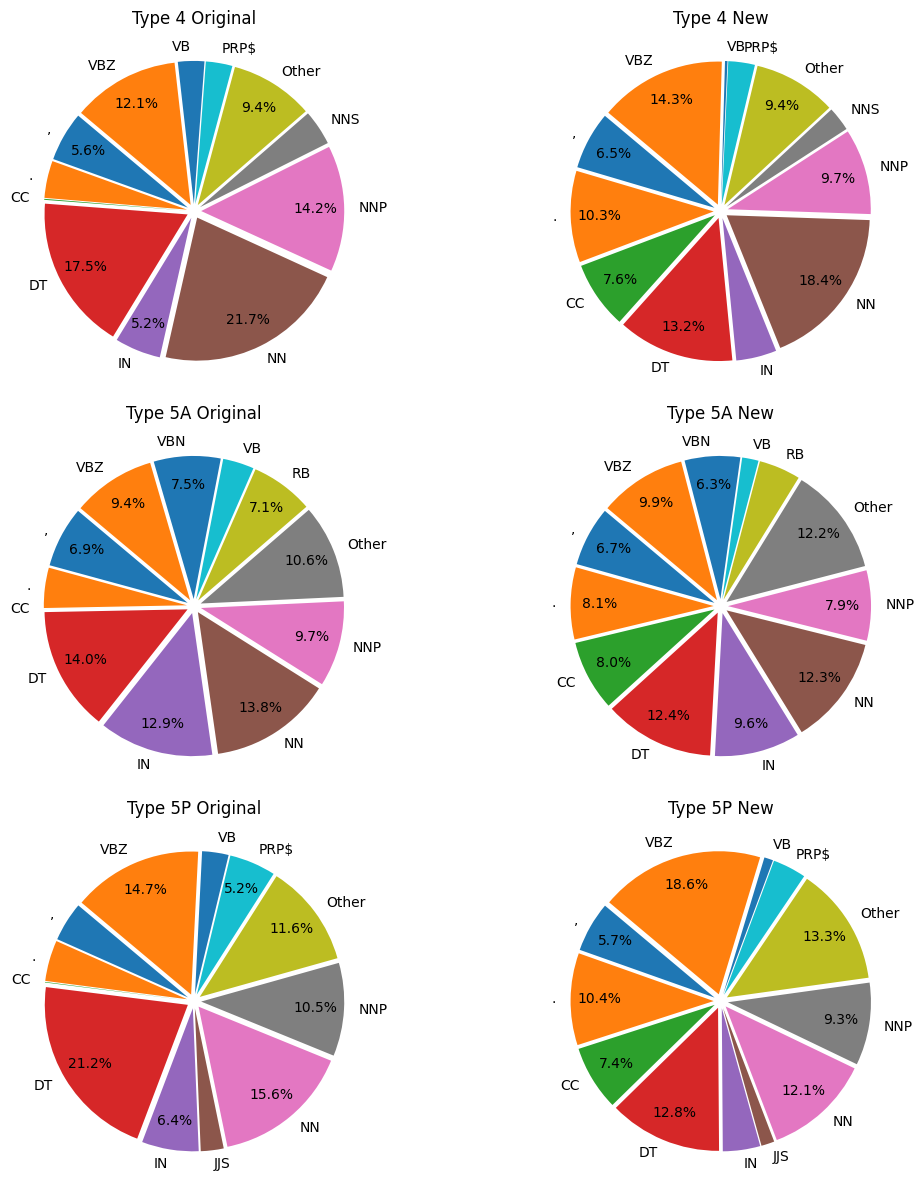

In [60]:
# RoBERTa Plots 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ig_by_pos_plot(axs[0,0], orig_data['type4'],'Type 4','Original')
ig_by_pos_plot(axs[0,1], new_data['type4'],'Type 4','New')

ig_by_pos_plot(axs[1,0], orig_data['type5a'],'Type 5A','Original')
ig_by_pos_plot(axs[1,1], new_data['type5a'],'Type 5A','New')

ig_by_pos_plot(axs[2,0], orig_data['type5p'],'Type 5P','Original')
ig_by_pos_plot(axs[2,1], new_data['type5p'],'Type 5P','New')

plt.tight_layout()
plt.savefig('Part4A_RoBERTa_POS.pdf',bbox_inches='tight')
plt.show()

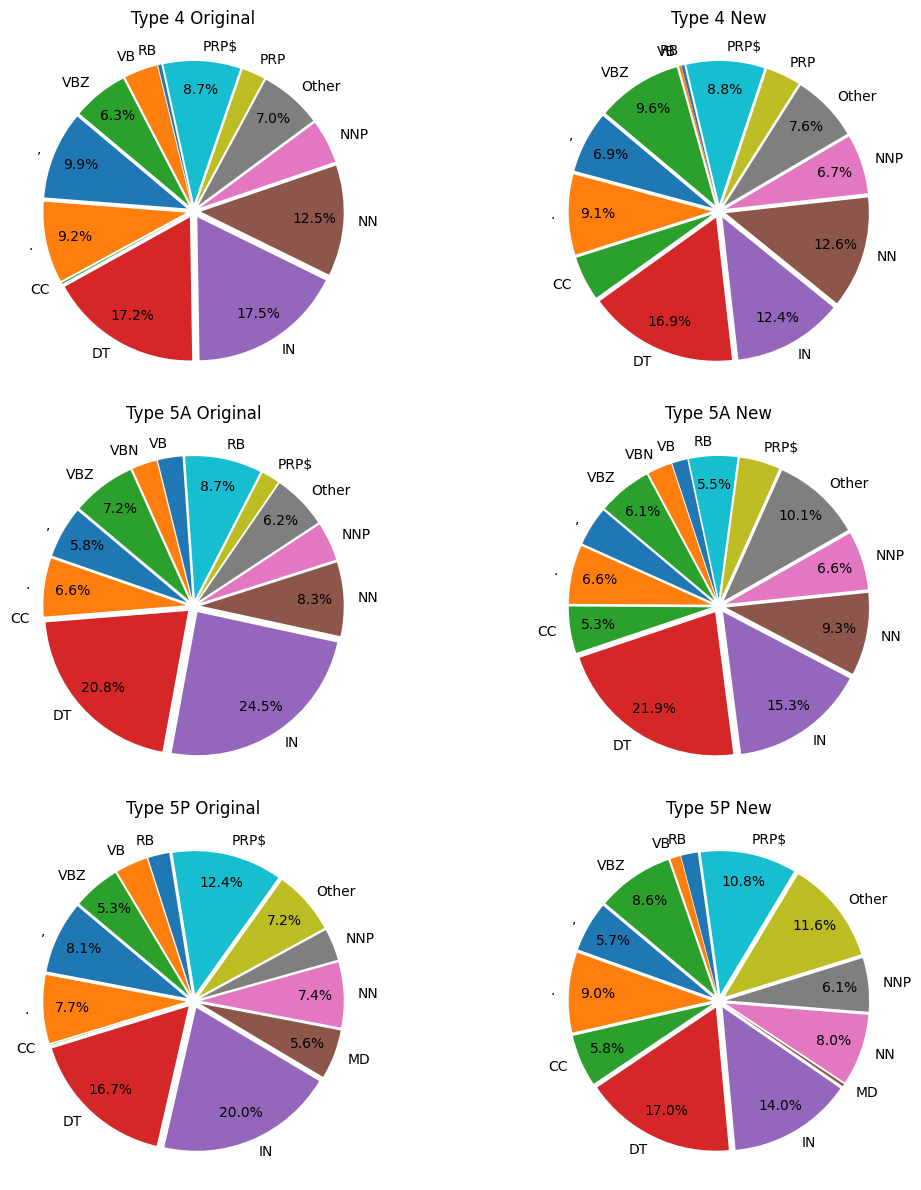

In [18]:
# DeBERTa 
orig_data = {}
new_data = {}

for sentence_type in ['type4','type5a','type5p']:
    df = pd.read_csv(f'/kaggle/input/confer-extension-results/Part4A/DeBERTa/part4a_{sentence_type}_deberta_results.csv',index_col=0)
    orig_data[sentence_type], new_data[sentence_type] = get_orig_new_pie_data(df)

# DeBERTa Plots 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ig_by_pos_plot(axs[0,0], orig_data['type4'],'Type 4','Original')
ig_by_pos_plot(axs[0,1], new_data['type4'],'Type 4','New')

ig_by_pos_plot(axs[1,0], orig_data['type5a'],'Type 5A','Original')
ig_by_pos_plot(axs[1,1], new_data['type5a'],'Type 5A','New')

ig_by_pos_plot(axs[2,0], orig_data['type5p'],'Type 5P','Original')
ig_by_pos_plot(axs[2,1], new_data['type5p'],'Type 5P','New')

plt.tight_layout()
plt.savefig('Part4A_DeBERTa_POS.pdf',bbox_inches='tight')
plt.show()


In [64]:
orig_data['type4']

,        0.038828
.        0.022896
CC       0.001213
DT       0.017297
FW       0.011728
IN       0.036980
NNP      0.059591
NNS      0.023767
Other   -0.220570
PRP      0.018094
UH       0.017780
VBG      0.012799
dtype: float64

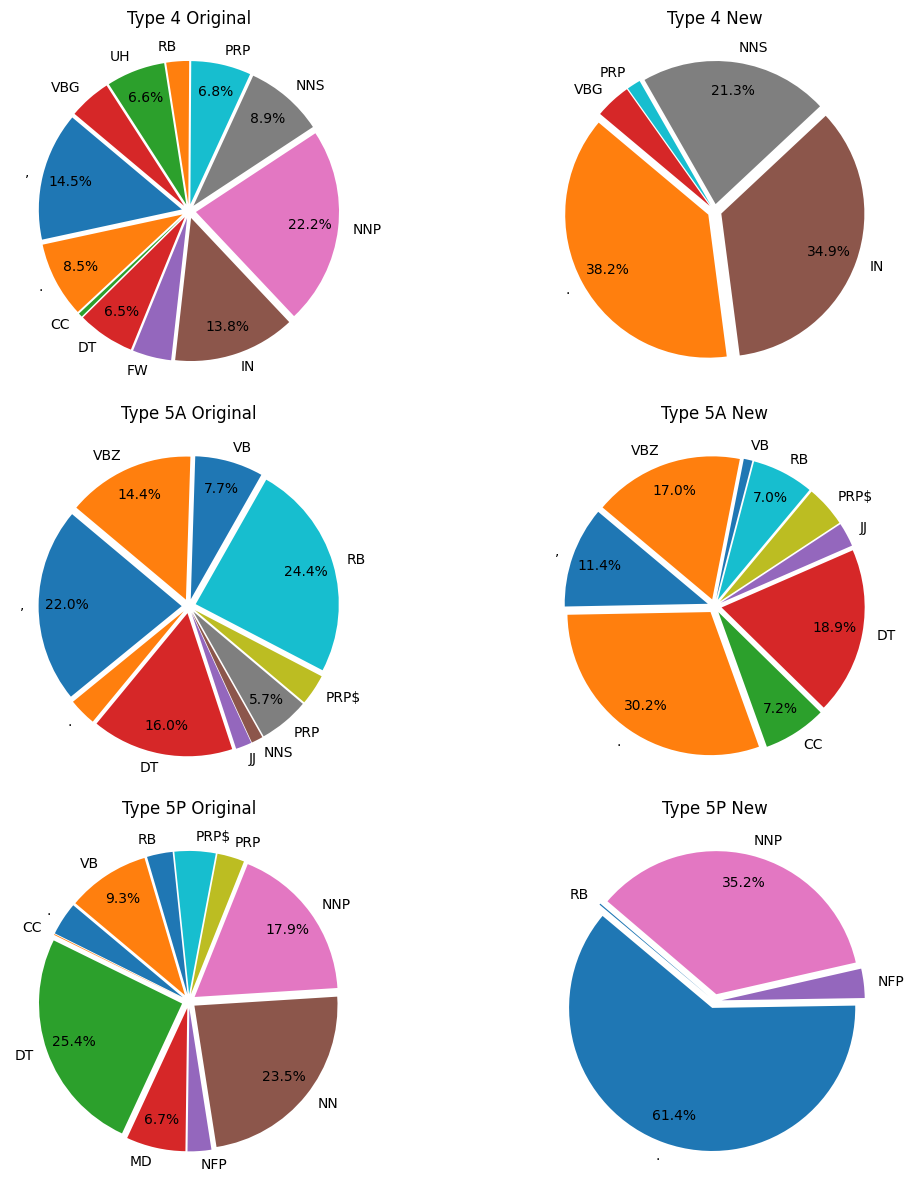

In [84]:
# Llama 
orig_data = {}
new_data = {}

for sentence_type in ['type4','type5a','type5p']:
    df = pd.read_csv(f'/kaggle/input/confer-extension-results/Part4A/Llama/part4a_{sentence_type}_llama_results.csv',index_col=0)
    orig_data[sentence_type], new_data[sentence_type] = get_orig_new_pie_data(df)

# Llama Plots 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ig_by_pos_plot(axs[0,0], orig_data['type4'],'Type 4','Original')
ig_by_pos_plot(axs[0,1], new_data['type4'],'Type 4','New')

ig_by_pos_plot(axs[1,0], orig_data['type5a'],'Type 5A','Original')
ig_by_pos_plot(axs[1,1], new_data['type5a'],'Type 5A','New')

ig_by_pos_plot(axs[2,0], orig_data['type5p'],'Type 5P','Original')
ig_by_pos_plot(axs[2,1], new_data['type5p'],'Type 5P','New')

plt.tight_layout()
plt.savefig('Part4A_Llama_POS.pdf',bbox_inches='tight')
plt.show()

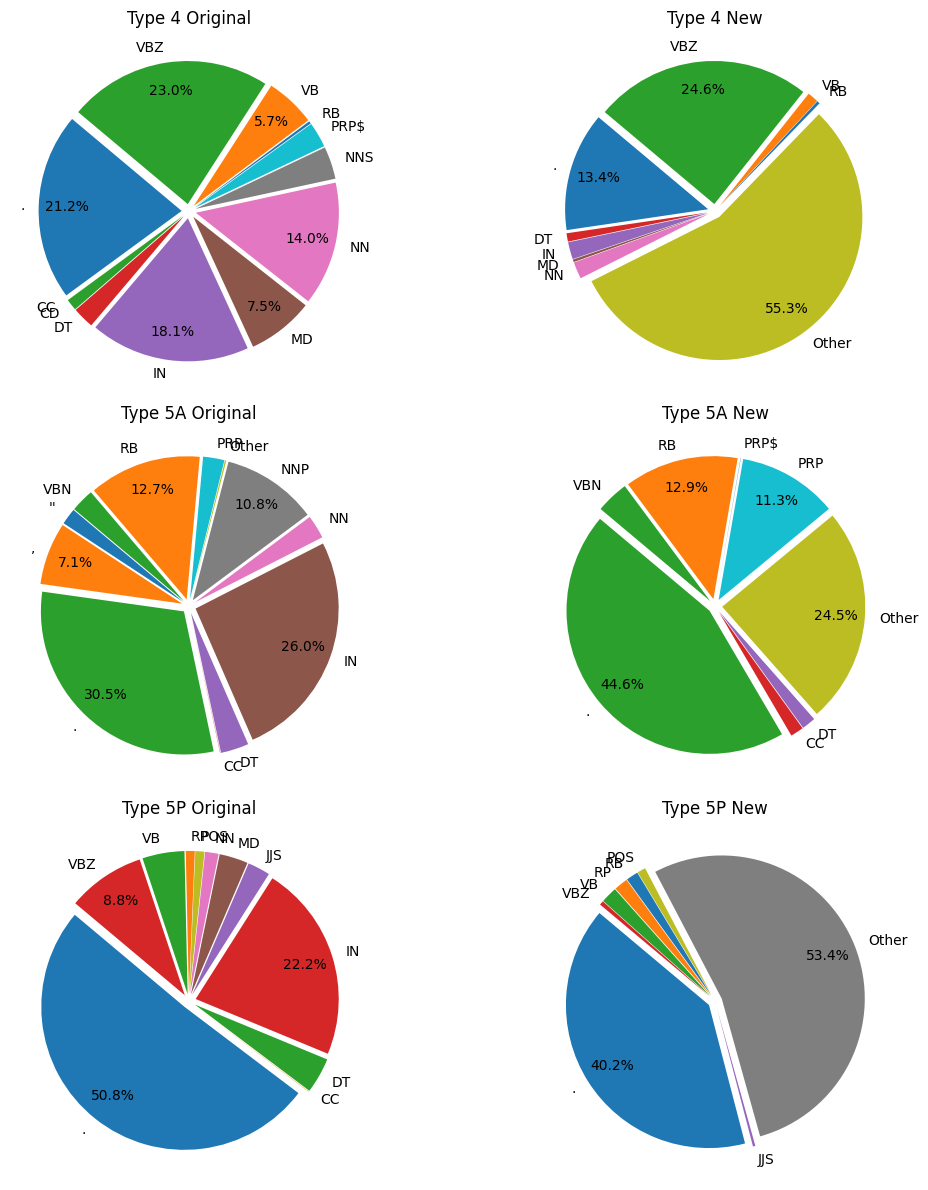

In [85]:
# Gemma 
orig_data = {}
new_data = {}

for sentence_type in ['type4','type5a','type5p']:
    df = pd.read_csv(f'/kaggle/input/confer-extension-results/Part4A/Gemma/part4a_{sentence_type}_gemma_results.csv',index_col=0)
    orig_data[sentence_type], new_data[sentence_type] = get_orig_new_pie_data(df)

# Gemma Plots 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ig_by_pos_plot(axs[0,0], orig_data['type4'],'Type 4','Original')
ig_by_pos_plot(axs[0,1], new_data['type4'],'Type 4','New')

ig_by_pos_plot(axs[1,0], orig_data['type5a'],'Type 5A','Original')
ig_by_pos_plot(axs[1,1], new_data['type5a'],'Type 5A','New')

ig_by_pos_plot(axs[2,0], orig_data['type5p'],'Type 5P','Original')
ig_by_pos_plot(axs[2,1], new_data['type5p'],'Type 5P','New')

plt.tight_layout()
plt.savefig('Part4A_Gemma_POS.pdf',bbox_inches='tight')
plt.show()

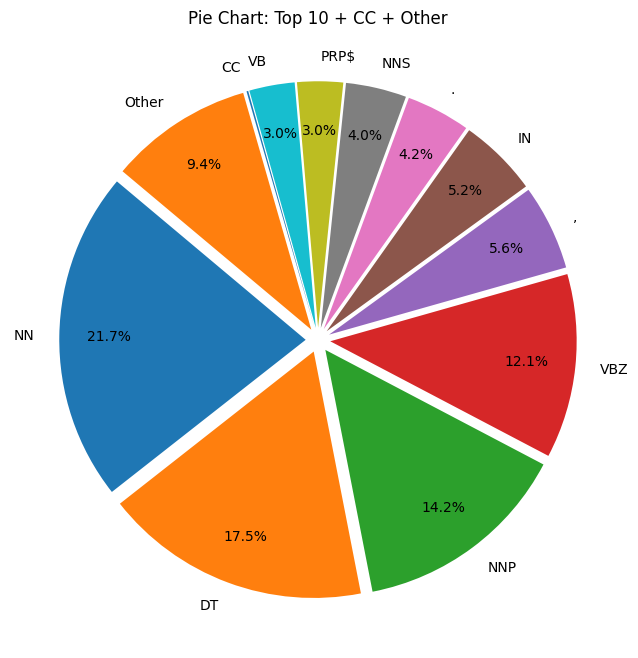

In [46]:
excluded_labels = top10.index
other_sum = type_totals['premise'][~type_totals['premise'].index.isin(excluded_labels)].sum()
pie_data = pd.concat([top10, pd.Series({'Other': other_sum})])
plt.figure(figsize=(8, 8))
plt.pie(pie_data, labels=pie_data.index, autopct=autopct_func, startangle=140, pctdistance=0.8, explode=[0.05] * len(pie_data))
plt.title('Pie Chart: Top 10 + CC + Other')
plt.show()

In [19]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/RoBERTa/part4a_type4_roberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = pd.DataFrame(compute_average_by_type(results_df))
type_averages.sort_values(by='premise',ascending=False) 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NN,0.199725,0.150648,0.117111,0.177812
DT,0.147662,0.098750,0.101781,0.144635
NNP,0.120431,0.088313,0.050597,0.119004
VBZ,0.163015,0.128760,0.071621,0.099094
XX,NaN,0.054453,0.003637,0.082912
VBN,0.056426,NaN,-0.042077,0.081808
.,0.195402,0.090156,0.080927,0.079172
VBD,0.041587,0.115847,0.021560,0.078018
NFP,NaN,0.073134,0.060970,0.072558
NNS,0.108944,0.058687,0.043427,0.071783


In [ ]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/RoBERTa/part4a_type4_roberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = pd.DataFrame(compute_average_by_type(results_df))
plot_results(type_averages)

/tmp/ipykernel_35/508570555.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Give space for suptitle
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


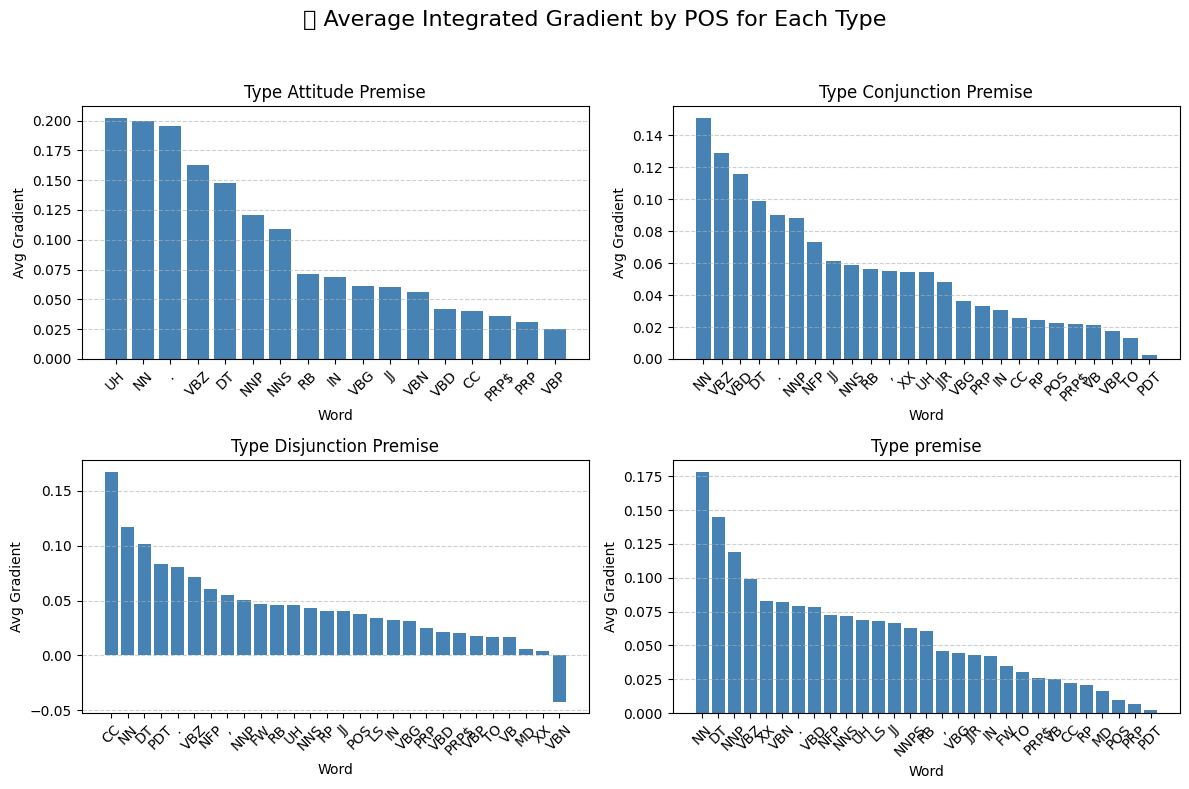

In [22]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/RoBERTa/part4a_type4_roberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = pd.DataFrame(compute_average_by_type(results_df))
plot_results(type_averages)

In [24]:
pd.DataFrame(type_averages)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.120431,0.088313,0.050597,0.119004
VBZ,0.163015,0.128760,0.071621,0.099094
IN,0.068868,0.030755,0.032269,0.042512
PRP$,0.036235,0.021835,0.020683,0.025896
NN,0.199725,0.150648,0.117111,0.177812
RB,0.071667,0.056372,0.046268,0.060970
.,0.195402,0.090156,0.080927,0.079172
DT,0.147662,0.098750,0.101781,0.144635
JJ,0.060140,0.061538,0.040646,0.066870
UH,0.201861,0.054252,0.045571,0.068482


## Type 5A

/tmp/ipykernel_35/2369488265.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Give space for suptitle
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


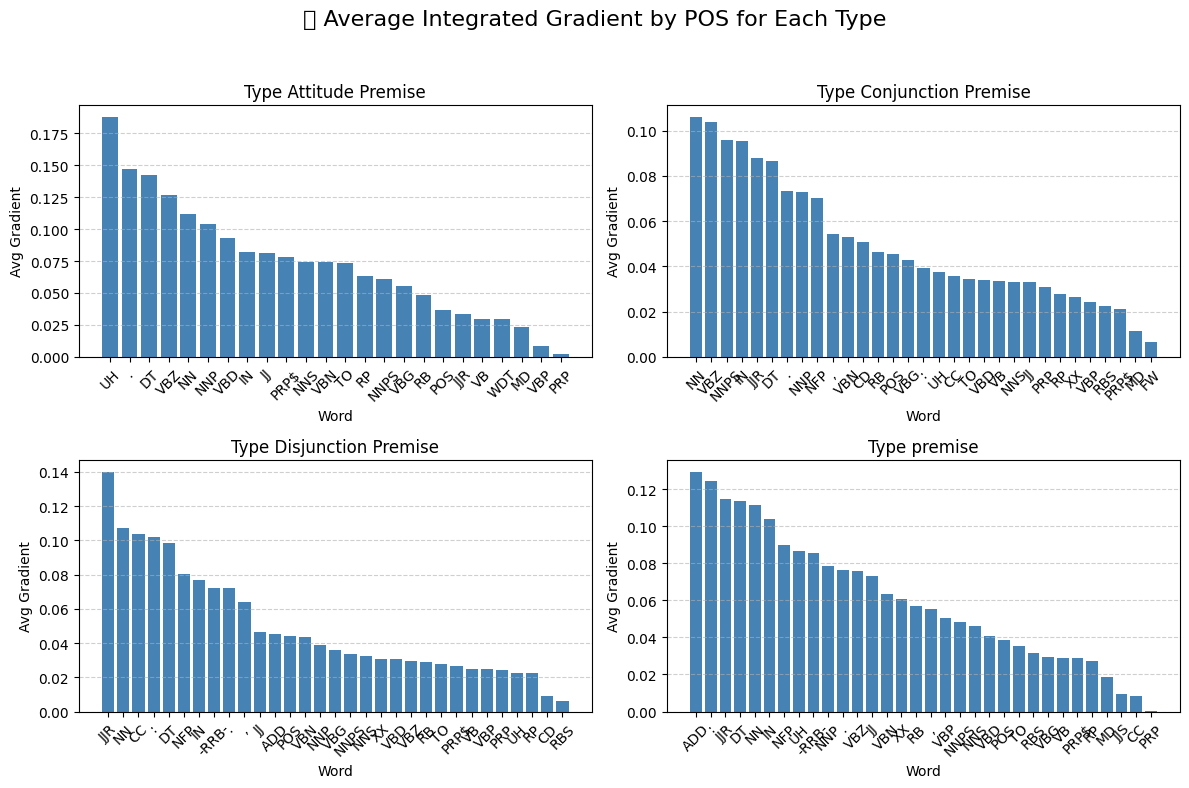

In [31]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/RoBERTa/part4a_type5a_roberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)

In [32]:
pd.DataFrame(type_averages)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.103788,0.072864,0.038938,0.078674
VBZ,0.127128,0.103988,0.029728,0.075681
MD,0.023470,0.011530,NaN,0.018771
VB,0.029785,0.033665,0.025046,0.028743
DT,0.142545,0.086402,0.098477,0.113545
NN,0.112054,0.105904,0.107120,0.111587
IN,0.081933,0.095209,0.076669,0.104069
RB,0.048574,0.046358,0.028687,0.057154
.,0.147076,0.073360,0.072186,0.076227
VBN,0.074071,0.052878,0.043443,0.063342


## Type 5P

/tmp/ipykernel_35/2369488265.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Give space for suptitle
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


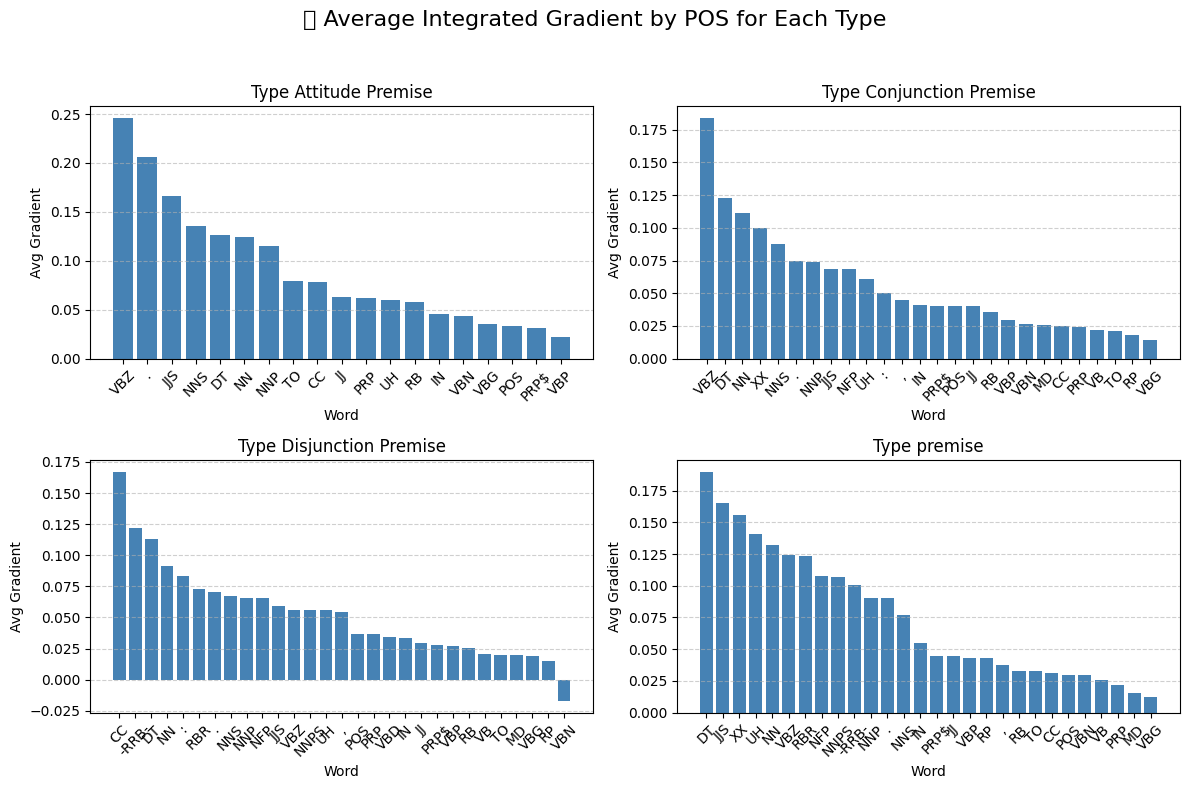

In [33]:
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/RoBERTa/part4a_type5p_roberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)

In [34]:
pd.DataFrame(type_averages)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.114797,0.073794,0.065962,0.090247
VBZ,0.245577,0.183649,0.056333,0.124578
IN,0.045570,0.040880,0.033516,0.054472
PRP$,0.031582,0.040637,0.027509,0.044962
NN,0.124670,0.111321,0.091268,0.132409
RB,0.058102,0.035845,0.025281,0.032682
.,0.206476,0.074447,0.070153,0.090107
DT,0.126872,0.122470,0.113125,0.189600
JJS,0.165884,0.068435,0.059369,0.165354
VBG,0.035151,0.013914,0.019357,0.012529


# DeBERTa

/tmp/ipykernel_35/2369488265.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Give space for suptitle
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


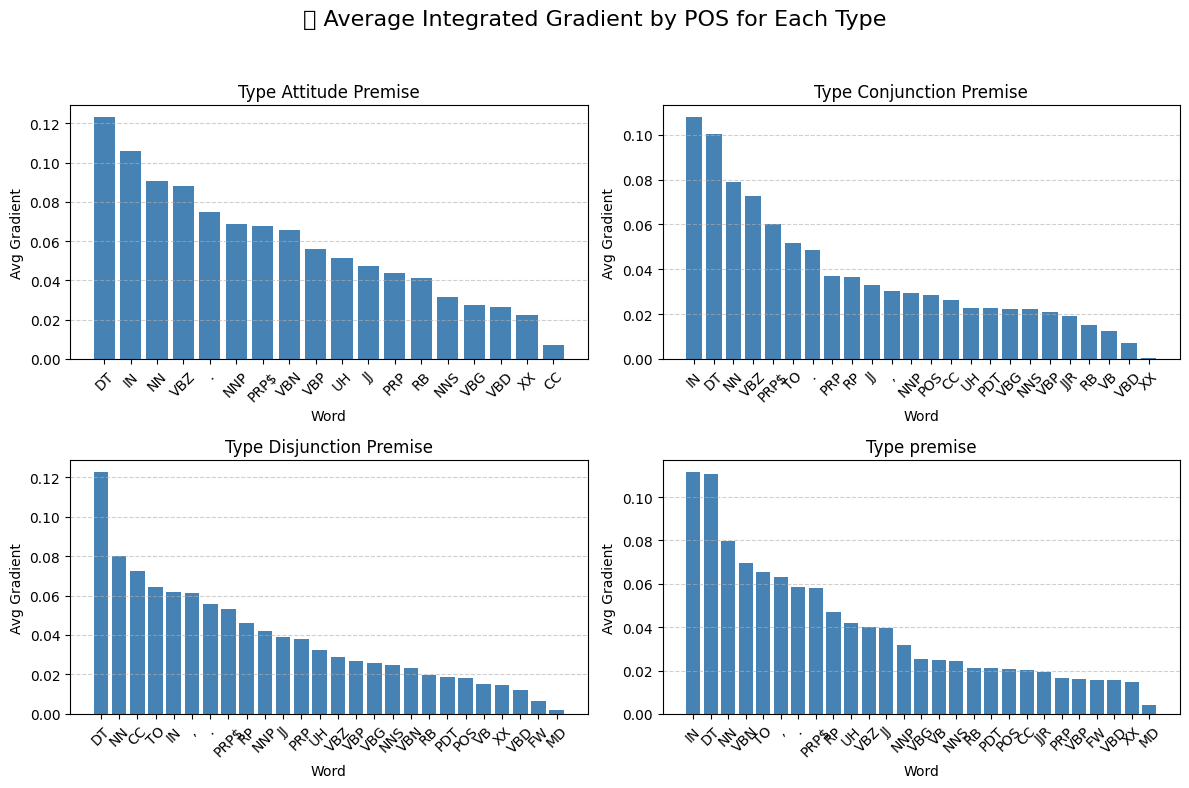

In [35]:
# type 4 
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/DeBERTa/part4a_type4_deberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)

In [37]:
pd.DataFrame(type_averages)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.068896,0.029555,0.042080,0.031886
VBZ,0.087909,0.072733,0.028878,0.040043
IN,0.106097,0.107785,0.061553,0.111381
PRP$,0.067730,0.060201,0.053074,0.058244
NN,0.090499,0.079134,0.080072,0.079579
RB,0.040995,0.015032,0.019721,0.021139
.,0.074900,0.048673,0.055793,0.058354
DT,0.122977,0.100387,0.122423,0.110649
JJ,0.047153,0.032942,0.038884,0.039455
UH,0.051626,0.022713,0.032418,0.042080


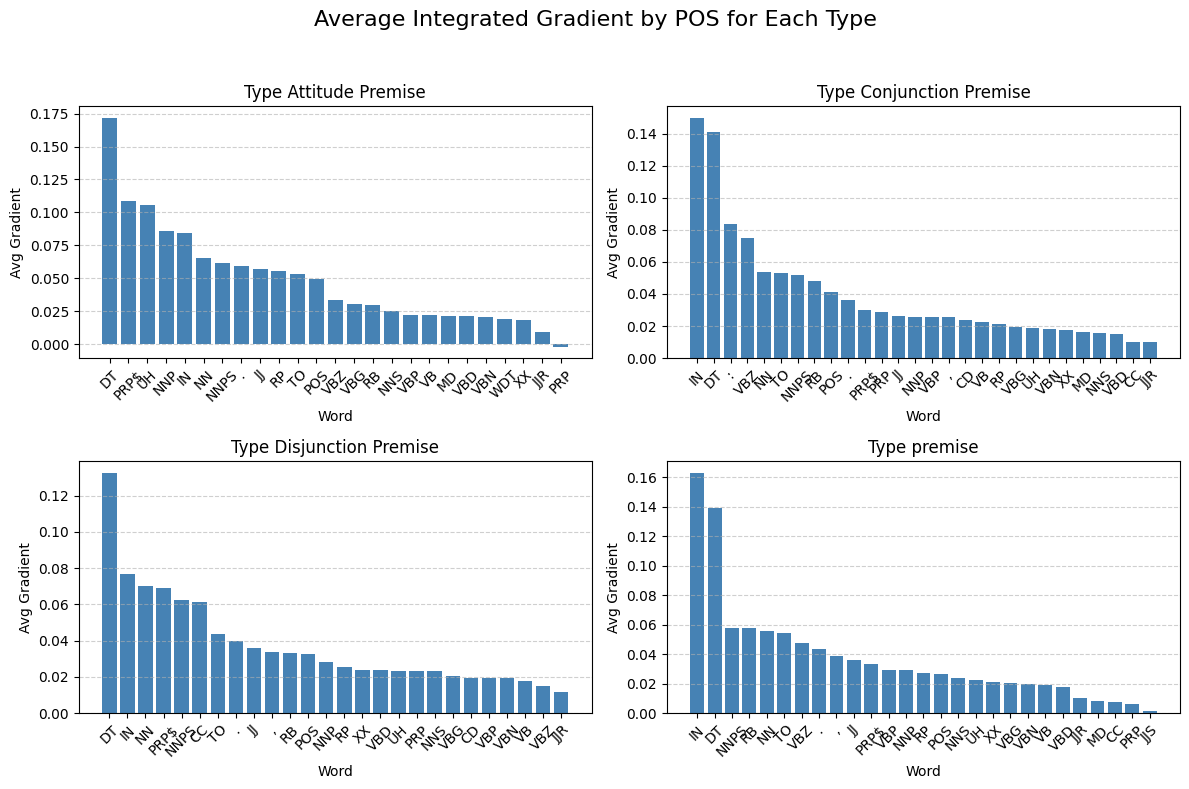

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.085830,0.025541,0.028127,0.029228
VBZ,0.033557,0.075026,0.015179,0.047631
MD,0.021715,0.016398,NaN,0.008415
VB,0.022040,0.022238,0.017593,0.018733
DT,0.171834,0.141030,0.132328,0.138815
NN,0.065598,0.053915,0.070385,0.055411
IN,0.084507,0.149664,0.076499,0.162664
RB,0.029537,0.048139,0.033211,0.057484
.,0.058953,0.036071,0.039941,0.043785
VBN,0.020591,0.018402,0.019160,0.019705


In [38]:
# type 5A 
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/DeBERTa/part4a_type5a_deberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)

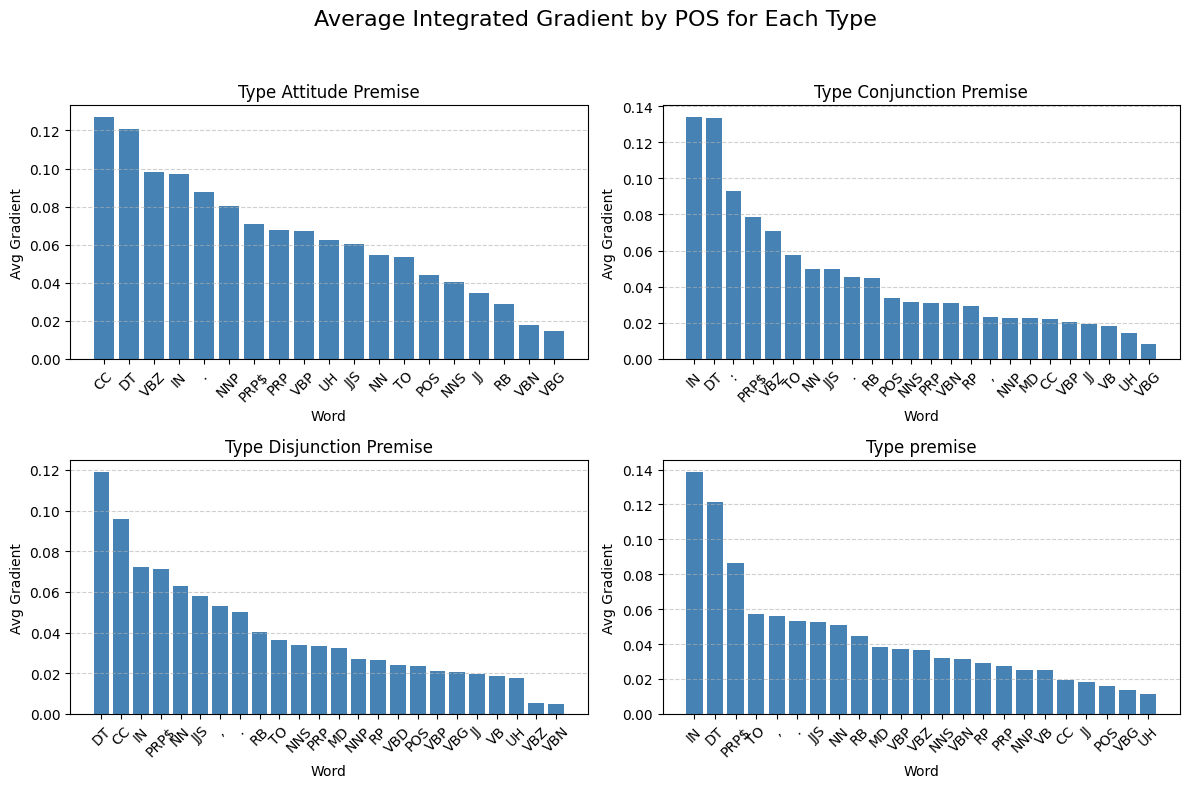

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.080238,0.022649,0.027056,0.025209
VBZ,0.098263,0.070839,0.005403,0.036702
IN,0.097032,0.133690,0.072172,0.138350
PRP$,0.070877,0.078588,0.071029,0.086566
NN,0.054628,0.049822,0.062835,0.050778
RB,0.028855,0.044761,0.040512,0.044473
.,0.087780,0.045121,0.050309,0.053170
DT,0.120682,0.133261,0.118788,0.121247
JJS,0.060496,0.049737,0.057882,0.052605
VBG,0.014650,0.008268,0.020723,0.013579


In [39]:
# type 5P
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/DeBERTa/part4a_type5p_deberta_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)

## Llama

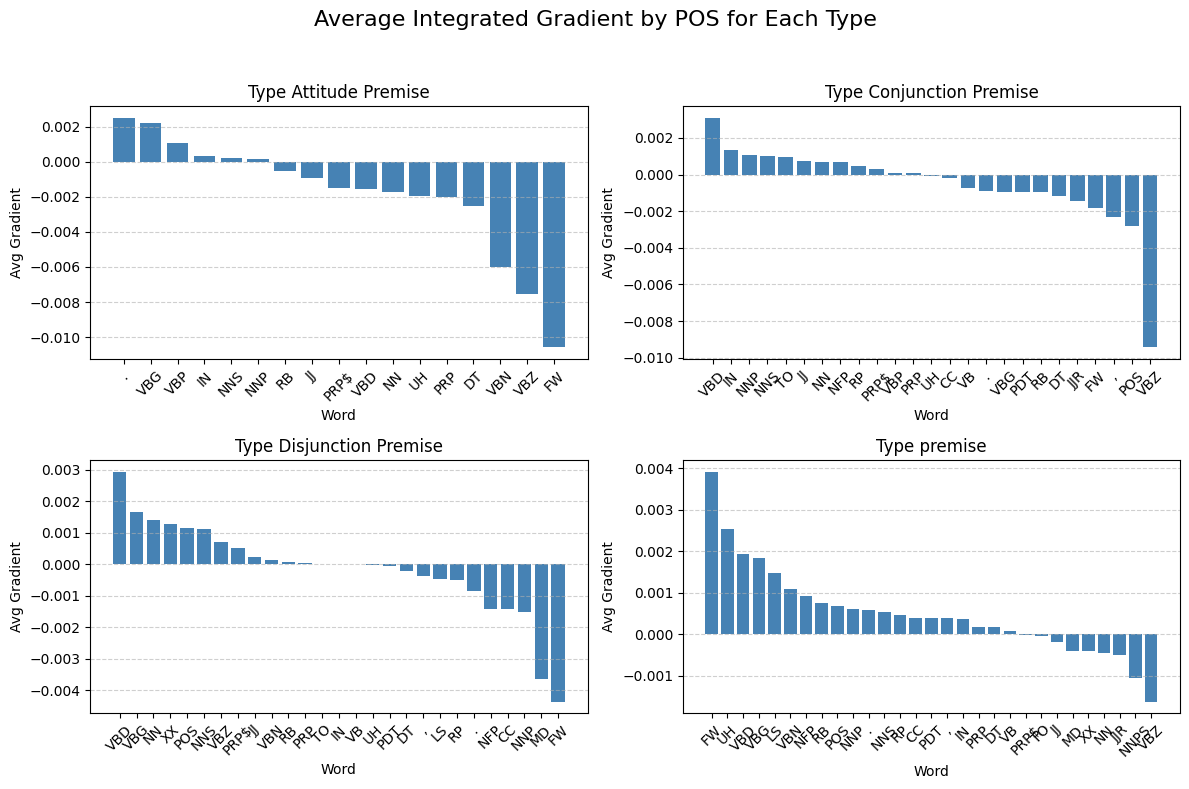

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.000177,0.001084,-0.001509,0.000614
VBZ,-0.007564,-0.009446,0.000710,-0.001615
IN,0.000344,0.001330,0.000023,0.000374
PRP$,-0.001471,0.000301,0.000507,-0.000019
NN,-0.001710,0.000703,0.001413,-0.000443
RB,-0.000553,-0.000952,0.000072,0.000765
.,0.002501,-0.000919,-0.000832,0.000587
DT,-0.002525,-0.001168,-0.000196,0.000176
JJ,-0.000918,0.000711,0.000246,-0.000182
UH,-0.001932,-0.000096,-0.000019,0.002540


In [40]:
# type 4
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/Llama/part4a_type4_llama_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)

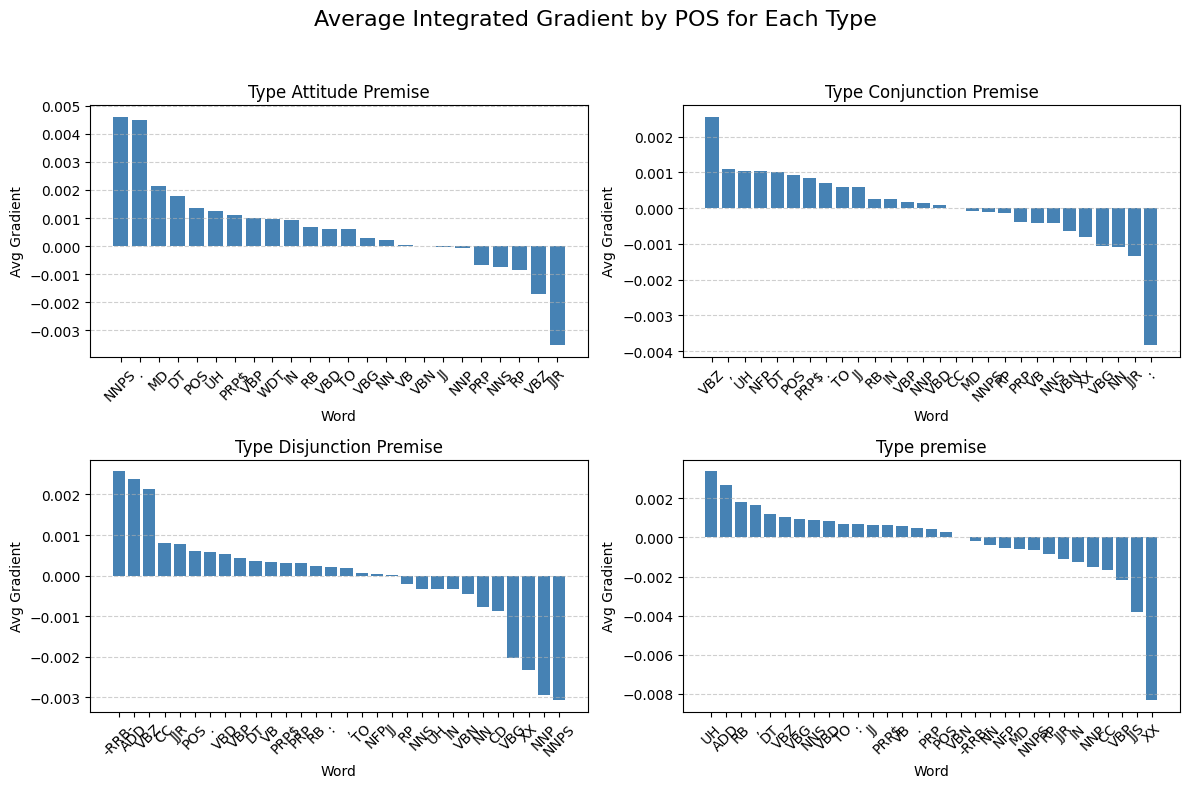

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,-0.000074,0.000154,-0.002959,-0.001497
VBZ,-0.001704,0.002558,0.002125,0.001073
MD,0.002131,-0.000079,NaN,-0.000600
VB,0.000036,-0.000417,0.000346,0.000582
DT,0.001788,0.001016,0.000368,0.001198
NN,0.000215,-0.001079,-0.000782,-0.000363
IN,0.000916,0.000263,-0.000341,-0.001274
RB,0.000679,0.000263,0.000230,0.001821
.,0.004498,0.000708,0.000592,0.000504
VBN,0.000006,-0.000625,-0.000459,0.000029


In [41]:
# type 5A
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/Llama/part4a_type5a_llama_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)

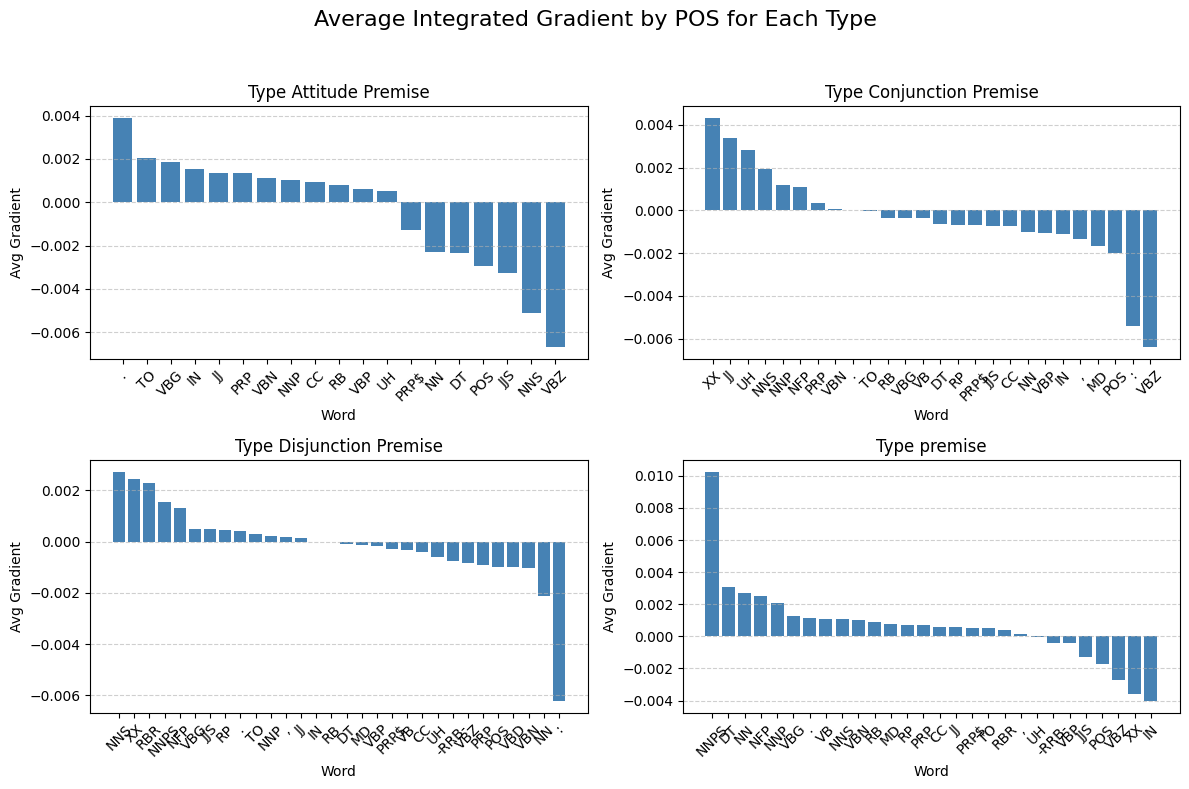

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.001045,0.001178,2.017397e-04,0.002085
VBZ,-0.006697,-0.006404,-8.561920e-04,-0.002727
IN,0.001554,-0.001089,-8.965675e-07,-0.004031
PRP$,-0.001286,-0.000690,-2.847495e-04,0.000536
NN,-0.002283,-0.001028,-2.112837e-03,0.002694
RB,0.000803,-0.000351,-3.742758e-05,0.000899
.,0.003902,0.000012,4.089430e-04,0.001174
DT,-0.002338,-0.000645,-1.042530e-04,0.003074
JJS,-0.003247,-0.000740,4.867284e-04,-0.001317
VBG,0.001869,-0.000363,4.947489e-04,0.001299


In [42]:
# type 5P
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/Llama/part4a_type5p_llama_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages) 

## Gemma

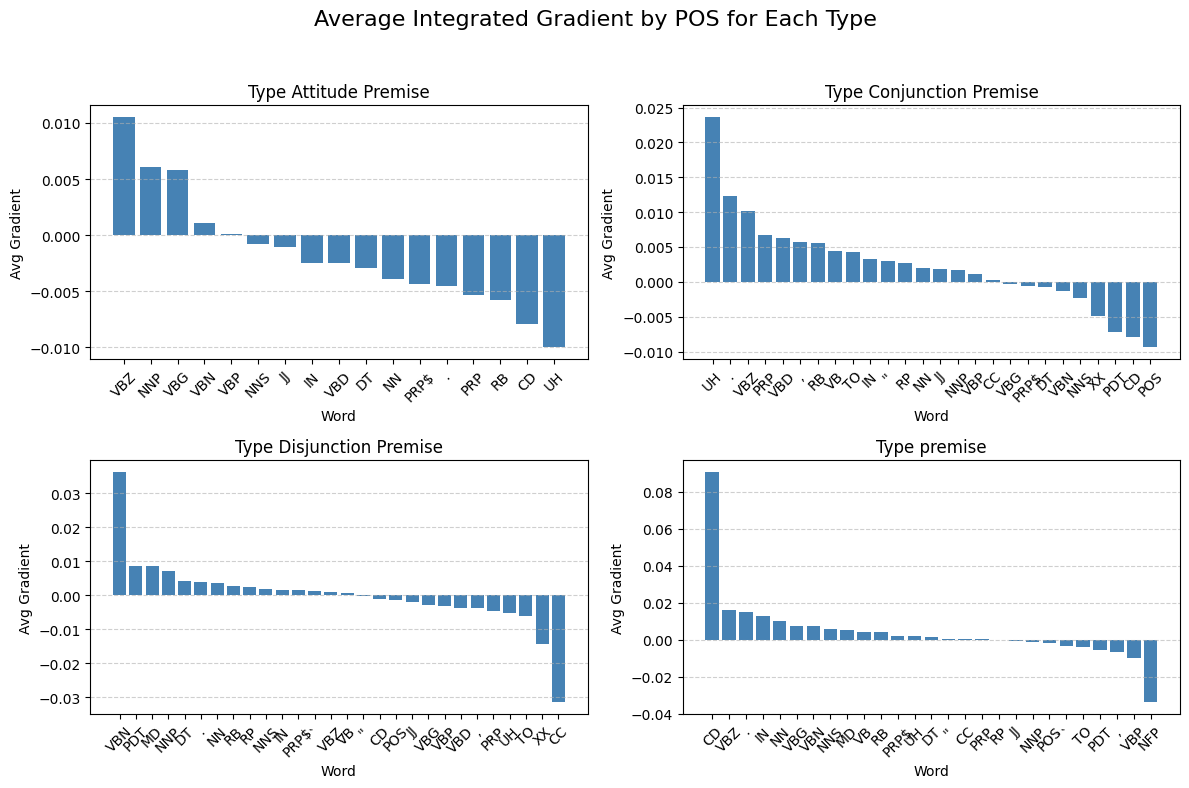

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.006044,0.001735,0.006991,-0.000992
VBZ,0.010540,0.010179,0.000900,0.016226
IN,-0.002477,0.003307,0.001670,0.012737
PRP$,-0.004377,-0.000565,0.001613,0.002085
NN,-0.003919,0.002048,0.003507,0.009876
RB,-0.005798,0.005635,0.002585,0.003987
.,-0.004491,0.012346,0.003976,0.014926
DT,-0.002920,-0.000803,0.004287,0.001724
JJ,-0.001014,0.001840,-0.002002,-0.000797
NNS,-0.000819,-0.002343,0.001937,0.005828


In [43]:
# type 4
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/Gemma/part4a_type4_gemma_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)

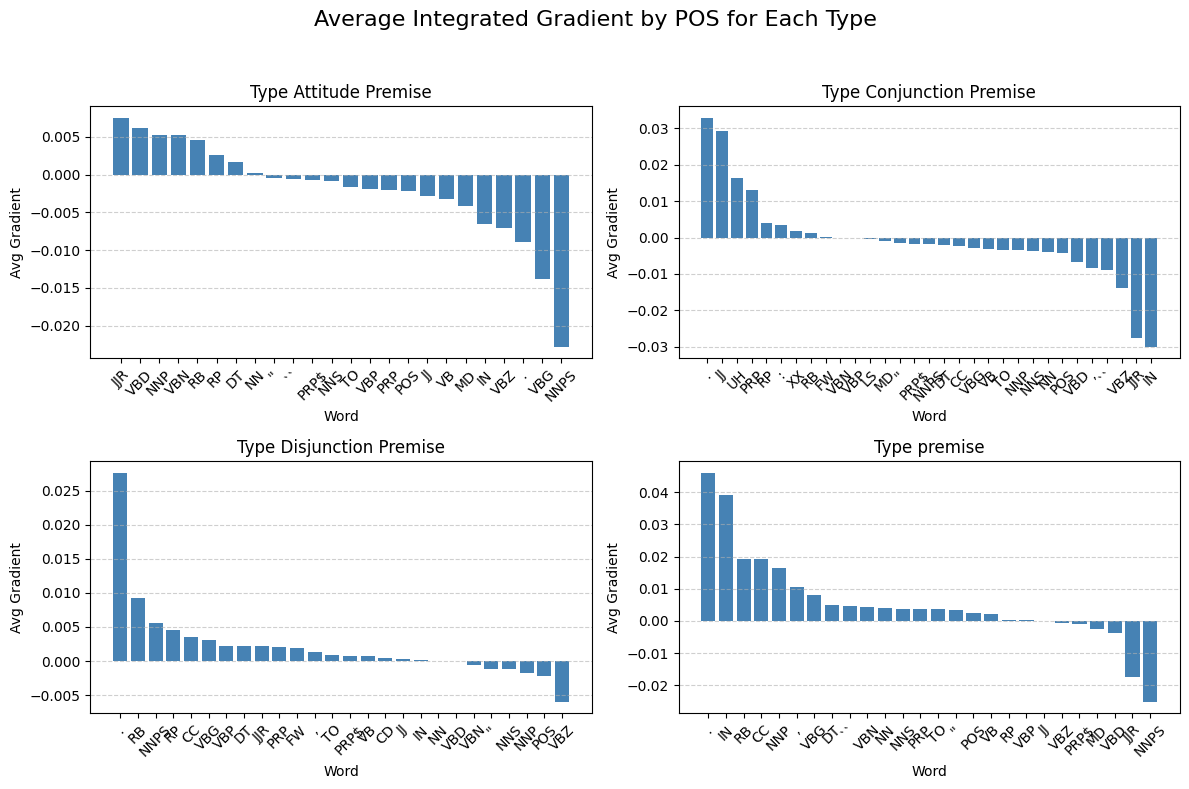

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.005238,-0.003493,-0.001684,0.016527
VBZ,-0.007076,-0.013866,-0.005935,-0.000771
PRP,-0.001999,0.012923,0.002112,0.003624
``,-0.000593,-0.009023,NaN,0.004486
MD,-0.004178,-0.000868,NaN,-0.002528
VB,-0.003263,-0.003042,0.000748,0.002213
DT,0.001614,-0.002029,0.002241,0.004792
NN,0.000172,-0.003899,0.000061,0.004027
IN,-0.006485,-0.029923,0.000216,0.039150
RB,0.004563,0.001151,0.009202,0.019137


In [44]:
# type 5A
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/Gemma/part4a_type5a_gemma_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)

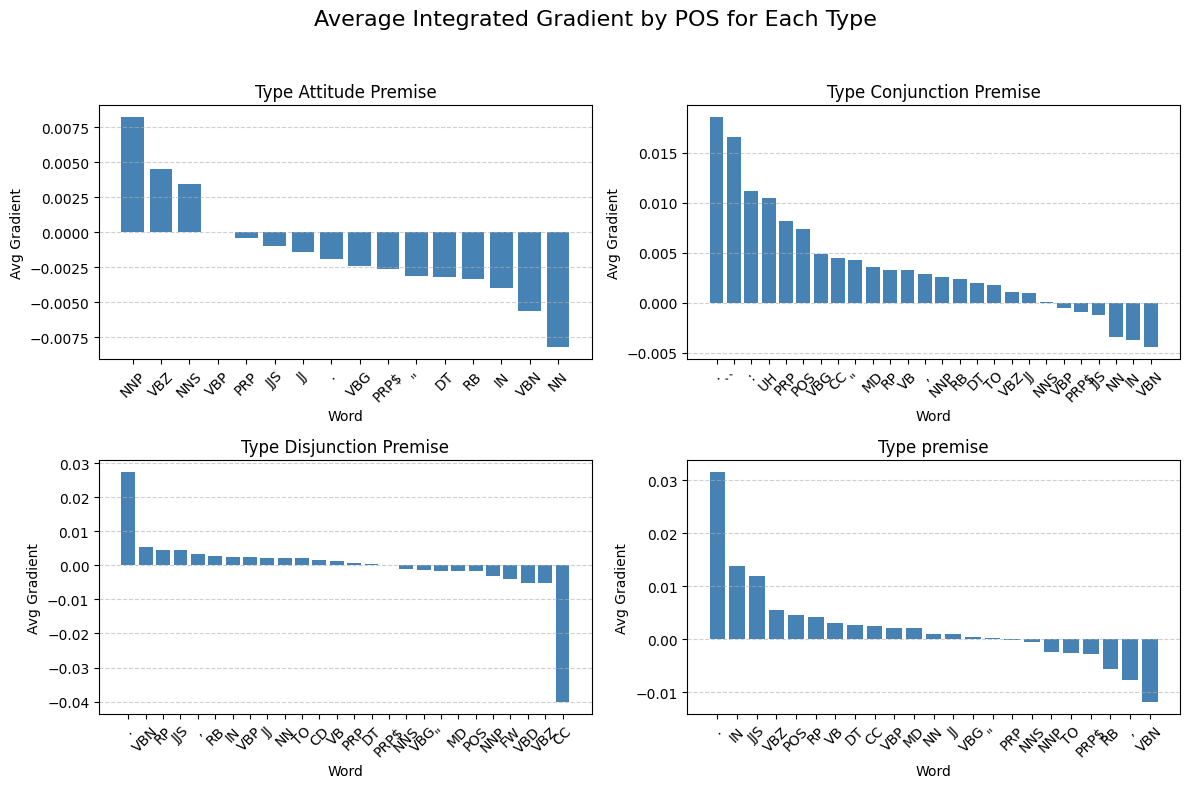

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Attitude Premise,Conjunction Premise,Disjunction Premise,premise
NNP,0.008260,0.002598,-0.003007,-0.002402
VBZ,0.004546,0.001064,-0.005094,0.005462
IN,-0.004001,-0.003716,0.002545,0.013827
PRP$,-0.002582,-0.000913,0.000130,-0.002769
NN,-0.008219,-0.003383,0.002123,0.000946
RB,-0.003344,0.002390,0.002849,-0.005561
.,-0.001924,0.018561,0.027432,0.031586
DT,-0.003171,0.002005,0.000364,0.002648
JJS,-0.000940,-0.001275,0.004483,0.011974
VBG,-0.002366,0.004867,-0.001457,0.000333


In [45]:
# type 5P
results_df = pd.read_csv('/kaggle/input/confer-extension-results/Part4A/Gemma/part4a_type5p_gemma_results.csv')
results_df['word_gradients'] = results_df['word_gradients'].apply(ast.literal_eval)
results_df['word_gradients'] = results_df['word_gradients'].apply(process_word_gradients)
results_df['pos_gradients'] = results_df['word_gradients'].apply(compute_gradient_by_pos)
type_averages = compute_average_by_type(results_df)
plot_results(type_averages)
pd.DataFrame(type_averages)